# This script performs the analysis in the supplemental materials including:
### Pred-prey trajectories with symmetric vs. asymmetric interaction strength, pred-prey abundances across predator harvest, and sensitivity analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import rc
import seaborn as sns
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from matplotlib.patches import Patch
from scipy.signal import find_peaks

## Pred - Prey Model Functions

In [2]:
def dNdt(H, P, parameters_dict):
    #Unpacking herbivore parameters:
    r_H = parameters_dict['r_H'] # growth rate of herbivores
    K_H = parameters_dict['K_H'] # carrying capacity of herbivores
    theta_H = parameters_dict['theta_H'] # immigration of herbivores
    c = parameters_dict['c'] # addition to predator from prey
    d = parameters_dict['d'] # value of H when predation half its max value
    q_H = parameters_dict['q_H'] # proportionality constant for herbivore harvest
    E_H = parameters_dict['E_H'] # Effort for herbivore harvest
    #Unpacking predator parameters:
    r_P = parameters_dict['r_P'] # growth rate of predator 
    K_P = parameters_dict['K_P'] # carrying capactiy of predators 
    b = parameters_dict['b'] # mortality to prey from predator
    theta_P = parameters_dict['theta_P'] # immigration of predators  
    q_P = parameters_dict['q_P'] # proportionality constant for predators harvest
    E_P = parameters_dict['E_P'] # Effort for predator harvest
    
    #Calculate the derivative 
    dH = r_H*H*(1-H/K_H) - (c*H*P)/(d+H) + theta_H - q_H*E_H*H
    dP = r_P*P*(1-P/K_P) + (b*H*P)/(d+H) + theta_P - q_P*E_P*P
    
    return dH, dP

In [3]:
# Function: numerical solver, 2nd order RK 

def RK2(H, P, parameters_dict):
    H_init = H
    P_init = P 
    
    dH1, dP1 = dNdt(H,P,parameters_dict)
    
    H1 = H + 0.5*dH1
    P1 = P + 0.5*dP1
    
    dH2, dP2 = dNdt(H1,P1,parameters_dict)
    
    dH_ave = (dH1+dH2)/2 
    dP_ave = (dP1+dP2)/2 
    
    H = H_init + dH_ave
    P = P_init + dP_ave
    
    #Calculate harvest 
    q_H = parameters_dict['q_H'] #proportionality constant for herbivore harvest 
    E_H = parameters_dict['E_H'] #Effort for herbivore harvest
    
    q_P = parameters_dict['q_P'] #proportionality constant for herbivore harvest 
    E_P = parameters_dict['E_P'] #Effort for herbivore harvest
    
    herbivore_harvest = q_H*E_H*H
    predator_harvest = q_P*E_P*P
    
    return H, P, herbivore_harvest, predator_harvest

In [4]:
# Function to run the model 

def run_model(INIT_H, INIT_P, parameters_dict):
    
    numyears = parameters_dict['numyears']
    
    H_array = np.zeros(numyears+1)
    P_array = np.zeros(numyears+1)
    H_harvest_array = np.zeros(numyears+1)
    P_harvest_array = np.zeros(numyears+1)
    
    H_array[0] = INIT_H #Starting biomass of herbivore 
    P_array[0] = INIT_P #Starting biomass of predator 
    H_harvest_array[0] = 0
    P_harvest_array[0] = 0
    
    for i in np.arange(0,numyears):
        H_array[i+1], P_array[i+1], H_harvest_array[i+1], P_harvest_array[i+1] \
            = RK2(H_array[i], P_array[i], parameters_dict)
        i = i+1
    
    return H_array, P_array, H_harvest_array, P_harvest_array

## Supplemental Fig 1 - Interaction Strength Trajectories

### Define a function to set to normal params

In [29]:
def default_params():
    numyears = 1000
    #Herbivore parameters:
    r_H = 0.4 # growth rate of herbivores
    K_H = 5000 # carrying capacity of herbivores
    theta_H = 50 # immigration of herbivores
    c = 0.4 #additional mortality of H 
    d = 500 # value of H when predation half its max value 
    q_H = 1. # proportionality constant for herbivore harvest 
    E_H = 0.0 # Effort for herbivore harvest (0.05 = limit cycle, 0.2 = stable state)
    #Predator parameters:
    r_P = 0.2 # growth rate of predator 
    K_P = 2000 # carrying capactiy of predators
    b = 0.4 # additional growth of P due to H
    theta_P = 10 # immigration of predators 
    q_P = 1. # proportionality constant for predator harvest 
    E_P = 0.0 # Effort for predator harvest

    parameters_dict = {'numyears': numyears, 
                  'r_H': r_H, 
                  'K_H': K_H, 
                  'theta_H': theta_H,
                  'c': c, 
                  'd': d, 
                  'E_H': E_H,
                  'q_H': q_H, 
                  'r_P': r_P,
                  'K_P': K_P,
                  'theta_P': theta_P, 
                  'b': b,
                  'q_P': q_P, 
                  'E_P': E_P,
                  }

    return parameters_dict

In [30]:
#Run model simulation; set params to default
parameters_dict = default_params()

#numyears = 100
H0 = 100
P0 = 10

H_array, P_array, H_harvest_array, P_harvest_array = run_model(H0, P0, parameters_dict)

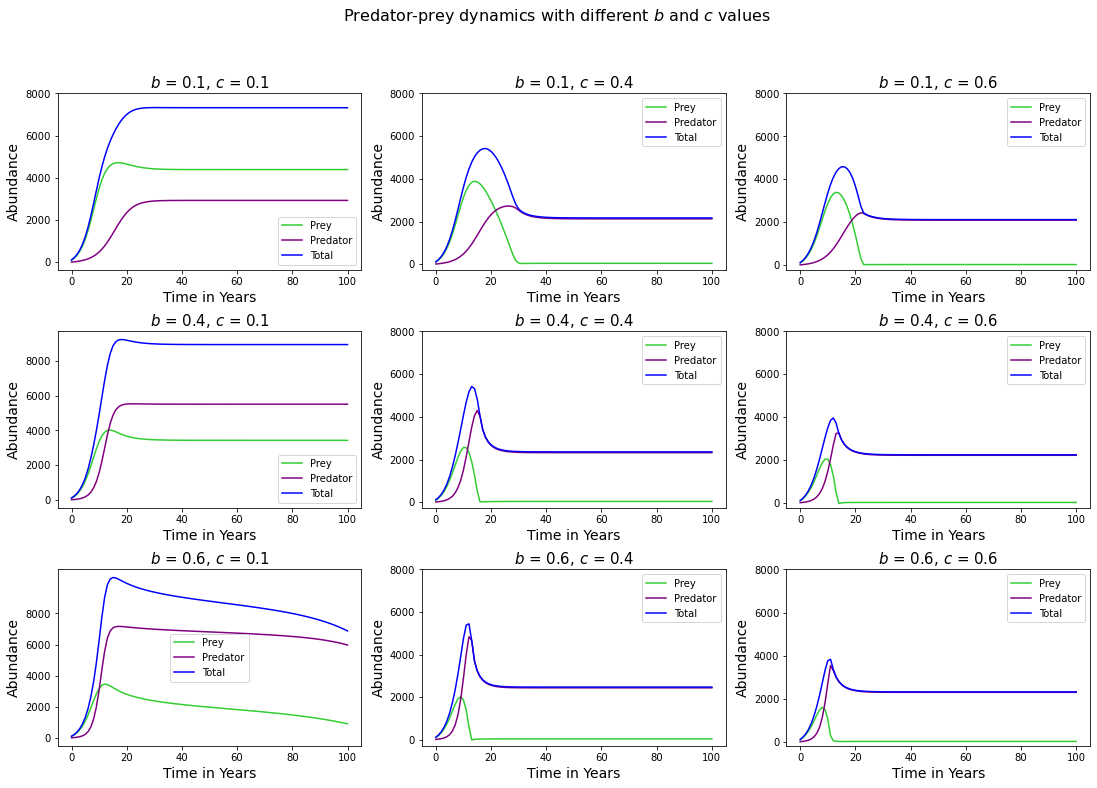

In [7]:
# Define interaction strengths
b_values = [0.1, 0.4, 0.6]
c_values = [0.1, 0.4, 0.6]
my_yticks = [0, 2000, 4000, 6000, 8000]

# To store results
results = {}

# Run model for each combination of b and c and store in results
for i, b in enumerate(b_values):
    for j, c in enumerate(c_values):
        parameters_dict['b'] = b
        parameters_dict['c'] = c
        H_array, P_array, H_harvest_array, P_harvest_array = run_model(H0, P0, parameters_dict)
        T_array = H_array + P_array  # Total abundance
        
        # Store the results in a dictionary
        results[(i, j)] = {
            'H_array': H_array,
            'P_array': P_array,
            'T_array': T_array
        }

# Plot trajectories
fig, axs = plt.subplots(3, 3, figsize=(18.5, 12))

for i in range(3):
    for j in range(3):
        H_array = results[(i, j)]['H_array']
        P_array = results[(i, j)]['P_array']
        T_array = results[(i, j)]['T_array']
        
        axs[i, j].plot(range(numyears + 1), H_array, label='Prey', color="limegreen")
        axs[i, j].plot(range(numyears + 1), P_array, label='Predator', color="purple")
        axs[i, j].plot(range(numyears + 1), T_array, label='Total', color="blue")
        axs[i, j].set_title(f'$b$ = {b_values[i]}, $c$ = {c_values[j]}', fontsize=15)
        axs[i, j].set_yticks(my_yticks)
        axs[i, j].set_xlabel('Time in Years', fontsize=14)
        axs[i, j].set_ylabel('Abundance', fontsize=14)
        axs[i, j].legend()

# Add a common title to the figure
fig.suptitle('Predator-prey dynamics with different $b$ and $c$ values', fontsize=16)
plt.subplots_adjust(wspace=0.2, hspace=0.35)

plt.savefig("manuscript_figs/time_series_abundance_total.jpg",
            format='jpeg',
            dpi=300,
            bbox_inches='tight')

plt.show()

## Supplemental Fig 2 - Predator Fishing

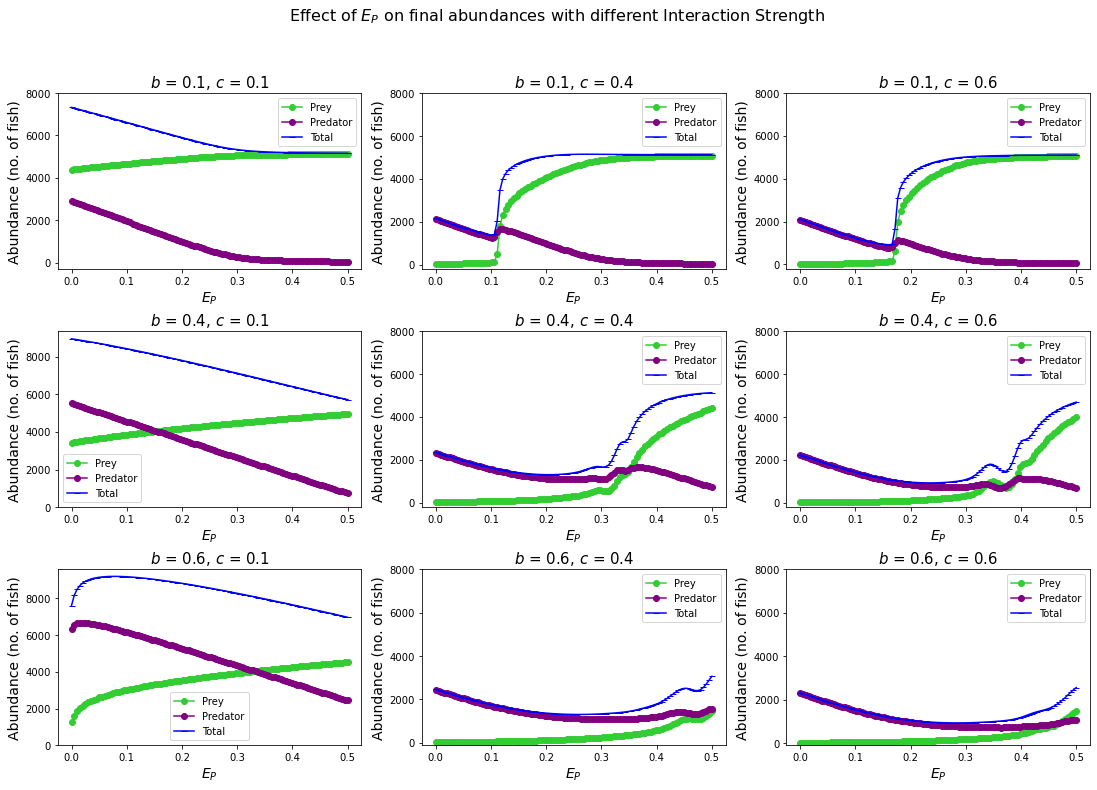

In [8]:
size = 100
E_P_array = np.linspace(0, 0.5, size)
H_final_array = np.zeros(size)
P_final_array = np.zeros(size)
H_harvest_final_array = np.zeros(size)
P_harvest_final_array = np.zeros(size)
b_values = [0.1, 0.4, 0.6]
c_values = [0.1, 0.4, 0.6]

# Y-axes Values 
my_yticks = [0, 2000, 4000, 6000, 8000]

#Set default params:
numyears = 100
parameters_dict = default_params()

#Initial conditions:
H0 = 100 
P0 = 10

# To store results
results = {}

# Run model for each combination of b and c and store in results
for i, b in enumerate(b_values):
    for j, c in enumerate(c_values):
        # Store the final abundances for different E_P values
        H_final_array = np.zeros(len(E_P_array))
        P_final_array = np.zeros(len(E_P_array))
        H_harvest_final_array = np.zeros(len(E_P_array))
        P_harvest_final_array = np.zeros(len(E_P_array))
        
        for k, E_P in enumerate(E_P_array):
            parameters_dict['b'] = b
            parameters_dict['c'] = c
            parameters_dict['E_P'] = E_P
            
            H_array, P_array, H_harvest_array, P_harvest_array = run_model(H0, P0, parameters_dict)
            
            # Calculate final values as the mean of the last 25 years
            H_final_array[k] = np.mean(H_array[-25:])
            P_final_array[k] = np.mean(P_array[-25:])
            H_harvest_final_array[k] = np.mean(H_harvest_array[-25:])
            P_harvest_final_array[k] = np.mean(P_harvest_array[-25:])
        
        # Store results
        results[(i, j)] = {
            'H_final_array': H_final_array,
            'P_final_array': P_final_array,
            'H_harvest_final_array': H_harvest_final_array,
            'P_harvest_final_array': P_harvest_final_array,
            'T_final_array': H_final_array + P_final_array  # Total abundance
        }

# Plot average of last 25 years of trajectories
fig, axs = plt.subplots(3, 3, figsize=(18.5, 12))

for i in range(3):
    for j in range(3):
        data = results[(i, j)]
        H_final_array = data['H_final_array']
        P_final_array = data['P_final_array']
        T_final_array = data['T_final_array']
        
        axs[i, j].plot(E_P_array, H_final_array, color="limegreen", marker='o', label='Prey')
        axs[i, j].plot(E_P_array, P_final_array, color="purple", marker='o', label='Predator')
        axs[i, j].plot(E_P_array, T_final_array, color="blue", marker='_', label='Total')
        axs[i, j].set_title(f'$b$ = {b_values[i]}, $c$ = {c_values[j]}', fontsize=15)
        axs[i, j].set_xlabel('$E_P$', fontsize=14)
        axs[i, j].set_ylabel('Abundance (no. of fish)', fontsize=14)
        axs[i, j].set_yticks(my_yticks)
        axs[i, j].legend()

# Add a common title to the figure
fig.suptitle('Effect of $E_P$ on final abundances with different Interaction Strength', fontsize=16)
plt.subplots_adjust(wspace=0.2, hspace=0.35)

plt.savefig("manuscript_figs/pred_fishing.jpg",
            format='jpeg',
            dpi=300,
            bbox_inches='tight')

plt.show()

## Supplemental Fig 3 - Sensitivity Analysis

/Users/SophiaRahnke/opt/miniconda3/envs/py36test/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in double_scalars
/Users/SophiaRahnke/opt/miniconda3/envs/py36test/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
/Users/SophiaRahnke/opt/miniconda3/envs/py36test/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
/Users/SophiaRahnke/opt/miniconda3/envs/py36test/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


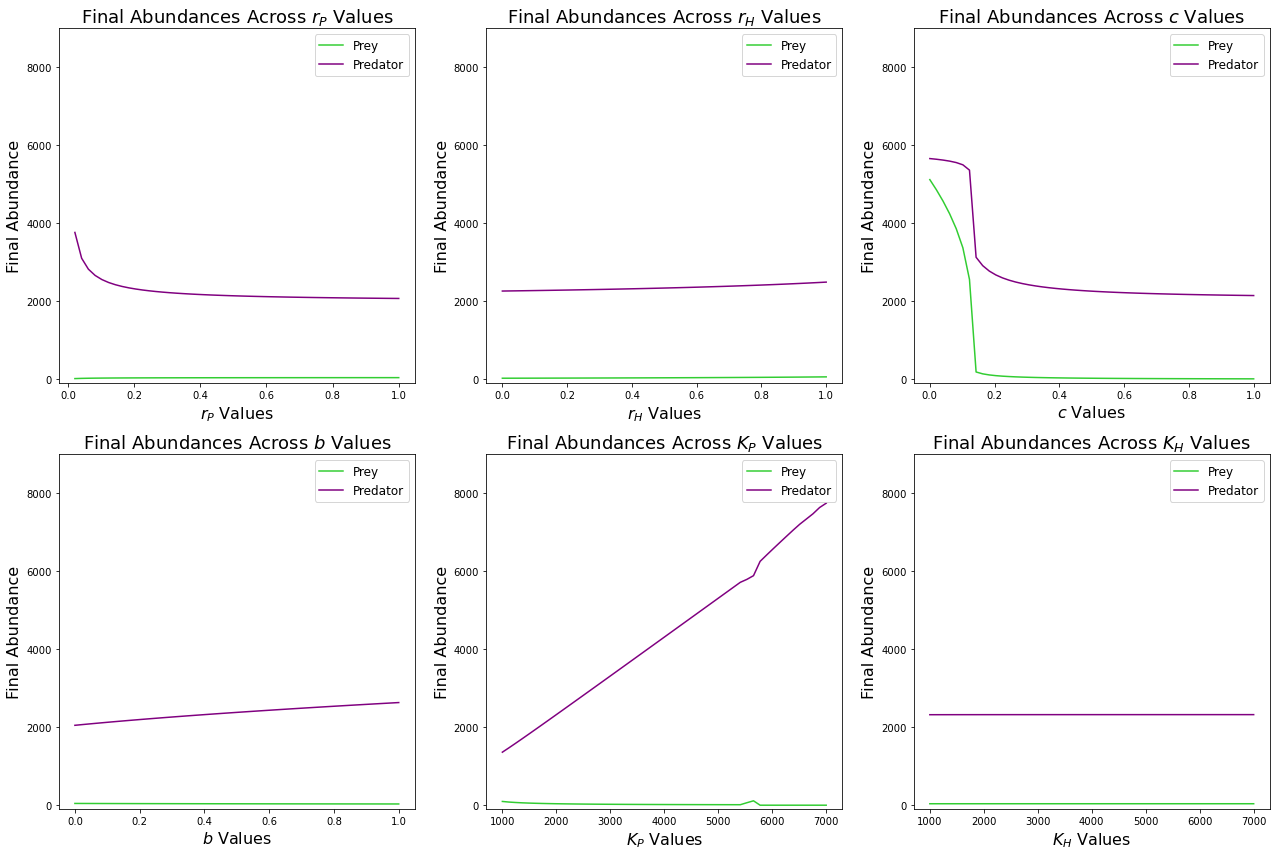

In [52]:
# Size of the parameter arrays
size = 50

# Parameter ranges to plot
param_ranges = {
    'r_P': np.linspace(0.0, 1.0, size),
    'r_H': np.linspace(0.0, 1.0, size),
    'c': np.linspace(0.0, 1.0, size),
    'b': np.linspace(0.0, 1.0, size),
    'K_P': np.linspace(1000, 7000, size),
    'K_H': np.linspace(1000, 7000, size)
}

# Storage for final abundances
final_abundances = {
    'r_P': (np.zeros(size), np.zeros(size)),
    'r_H': (np.zeros(size), np.zeros(size)),
    'c': (np.zeros(size), np.zeros(size)),
    'b': (np.zeros(size), np.zeros(size)),
    'K_P': (np.zeros(size), np.zeros(size)),
    'K_H': (np.zeros(size), np.zeros(size))
}

# Compute final abundances for each parameter range
for param, values in param_ranges.items():
    H_final, P_final = np.zeros(size), np.zeros(size)
    for i, value in enumerate(values):
        params = default_params()
        params[param] = value
        
        # Run model
        H_array, P_array, H_harvest_array, P_harvest_array = run_model(H0, P0, params)
        
        # Final abundances as the mean of the last 25 time steps
        H_final[i] = np.mean(H_array[-25:])
        P_final[i] = np.mean(P_array[-25:])
        
        # Any negative values to zero
        H_final[i] = max(H_final[i], 0)
        P_final[i] = max(P_final[i], 0)
    
    # Store the results
    final_abundances[param] = (H_final, P_final)

# Plot results
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# Titles and labels for each subplot
titles = [
    'Final Abundances Across $r_P$ Values',
    'Final Abundances Across $r_H$ Values',
    'Final Abundances Across $c$ Values',
    'Final Abundances Across $b$ Values',
    'Final Abundances Across $K_P$ Values',
    'Final Abundances Across $K_H$ Values'
]

x_labels = [
    '$r_P$ Values',
    '$r_H$ Values',
    '$c$ Values',
    '$b$ Values',
    '$K_P$ Values',
    '$K_H$ Values'
]

y_labels = 'Final Abundance'

# Plot for each parameter
for idx, (param, (H_final, P_final)) in enumerate(final_abundances.items()):
    row = idx // 3
    col = idx % 3
    
    axs[row, col].plot(param_ranges[param], H_final, label='Prey', color="limegreen")
    axs[row, col].plot(param_ranges[param], P_final, label='Predator', color="purple")
    axs[row, col].set_title(titles[idx], fontsize=18)
    axs[row, col].set_xlabel(x_labels[idx], fontsize=16)
    axs[row, col].set_ylabel(y_labels, fontsize=16)
    axs[row, col].set_ylim(-100, 9000)
    axs[row, col].legend(fontsize=12)

plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.2)

#plt.savefig("manuscript_figs/sensitivity.jpg",
 #           format='jpeg',
  #          dpi=300,
   #         bbox_inches='tight')

plt.show()

## Supplemental Fig 4 - b and c values

In [9]:
#Run model simulation; set params to default
parameters_dict = default_params()

numyears = 100
H0 = 100
P0 = 10

H_array, P_array, H_harvest_array, P_harvest_array = run_model(H0, P0, parameters_dict)

In [10]:
# Set b_array and c_array
size = 1000
b_array = np.linspace(0, 1.0, size)  # Example range of b values
c_array = np.linspace(0, 1.0, size)  # Example range of c values

# Initialize arrays to store the last values of H and P
H_last = np.zeros((size, size))
P_last = np.zeros((size, size))

# Run the model for each combination of b and c
for i in range(size):
    for j in range(size):
        b = b_array[i]
        c = c_array[j]
        parameters_dict['b'] = b
        parameters_dict['c'] = c
        H_array, P_array, H_harvest_array, P_harvest_array = run_model(H0, P0, parameters_dict)
        H_last[i, j] = np.mean(H_array[-10:])  # Take the mean of the last 10 values
        P_last[i, j] = np.mean(P_array[-10:])

In [11]:
# Define a small threshold for near-zero values
predator_extinction = 10
prey_extinction = 50

# Create masks with a threshold for near-zero conditions (representing local extirpation)
mask_P_dominated = (H_last < prey_extinction) & (P_last > predator_extinction) # Predator domination (H ≈ 0, P > 0)
mask_H_dominated = (P_last < predator_extinction) & (H_last > prey_extinction) # Prey domination (H > 0, P ≈ 0)
mask_extinction = (H_last < prey_extinction) & (P_last < predator_extinction)  # Extinction (H ≈ 0, P ≈ 0)
mask_coexistence = (H_last > prey_extinction) & (P_last > predator_extinction)  # Coexistence (H > 0, P > 0)

# Create an empty array
region_data = np.zeros((size, size))

# Populate the region_data array with the mask values
region_data[mask_extinction] = 1
region_data[mask_P_dominated] = 2
region_data[mask_H_dominated] = 3
region_data[mask_coexistence] = 4

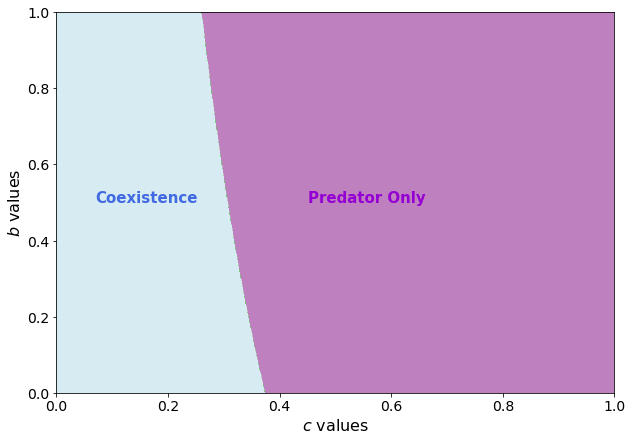

In [12]:
# Create a custom colormap for qualitative regions
cmap = ListedColormap(['purple', 'gray', 'green', 'lightblue'])


# Create figure with the colormap
plt.figure(figsize=(10, 7))
plt.imshow(region_data, cmap=cmap, extent=[min(c_array), max(c_array), min(b_array), max(b_array)], origin='lower', aspect='auto', alpha=0.5)

# Add text annotations for the different regions
plt.text(0.45, 0.5, 'Predator Only', color='darkviolet', fontsize=15, fontweight='bold', transform=plt.gca().transAxes)
plt.text(0.07, 0.5, 'Coexistence', color='royalblue', fontsize=15, fontweight='bold', transform=plt.gca().transAxes)

# Label the axes and add title
plt.xlabel("$c$ values", fontsize = 16)
plt.ylabel("$b$ values", fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.savefig("manuscript_figs/b_c_regions.jpg",
            format='jpeg',
            dpi=300,
            bbox_inches='tight')

plt.show()

# Redo with new thresholds and cycle detector

In [15]:
#Run model simulation; set params to default
parameters_dict = default_params()

numyears = 400
H0 = 100
P0 = 10

H_array, P_array, H_harvest_array, P_harvest_array = run_model(H0, P0, parameters_dict)

In [17]:
# Set b_array and c_array
size = 100
b_array = np.linspace(0, 1.0, size)  # Example range of b values
c_array = np.linspace(0, 1.0, size)  # Example range of c values

# Initialize arrays to store the last values of H and P
H_last = np.zeros((size, size))
P_last = np.zeros((size, size))

# Run the model for each combination of b and c
for i in range(size):
    for j in range(size):
        b = b_array[i]
        c = c_array[j]
        parameters_dict['b'] = b
        parameters_dict['c'] = c
        H_array, P_array, H_harvest_array, P_harvest_array = run_model(H0, P0, parameters_dict)
        H_last[i, j] = np.mean(H_array[-100:])  # Take the mean of the last 10 values
        P_last[i, j] = np.mean(P_array[-100:])

In [18]:
# Define a small threshold for near-zero values
predator_extinction = 20
prey_extinction = 250

# Create masks with a threshold for near-zero conditions (representing local extirpation)
mask_P_dominated = (H_last < prey_extinction) & (P_last > predator_extinction) # Predator domination (H ≈ 0, P > 0)
mask_H_dominated = (P_last < predator_extinction) & (H_last > prey_extinction) # Prey domination (H > 0, P ≈ 0)
mask_extinction = (H_last < prey_extinction) & (P_last < predator_extinction)  # Extinction (H ≈ 0, P ≈ 0)
mask_coexistence = (H_last > prey_extinction) & (P_last > predator_extinction)  # Coexistence (H > 0, P > 0)

# Create an empty array
region_data = np.zeros((size, size))

# Populate the region_data array with the mask values
region_data[mask_extinction] = 1
region_data[mask_P_dominated] = 2
region_data[mask_H_dominated] = 3
region_data[mask_coexistence] = 4

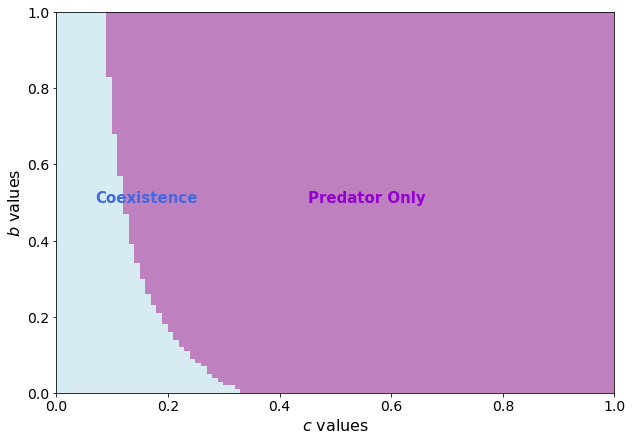

In [19]:
# Create a custom colormap for qualitative regions
cmap = ListedColormap(['purple', 'gray', 'green', 'lightblue'])


# Create figure with the colormap
plt.figure(figsize=(10, 7))
plt.imshow(region_data, cmap=cmap, extent=[min(c_array), max(c_array), min(b_array), max(b_array)], origin='lower', aspect='auto', alpha=0.5)

# Add text annotations for the different regions
plt.text(0.45, 0.5, 'Predator Only', color='darkviolet', fontsize=15, fontweight='bold', transform=plt.gca().transAxes)
plt.text(0.07, 0.5, 'Coexistence', color='royalblue', fontsize=15, fontweight='bold', transform=plt.gca().transAxes)

# Label the axes and add title
plt.xlabel("$c$ values", fontsize = 16)
plt.ylabel("$b$ values", fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

#plt.savefig("manuscript_figs/b_c_regions.jpg",
 #           format='jpeg',
  #          dpi=300,
   #         bbox_inches='tight')

plt.show()

In [50]:
def detect_cycles(ts, min_peaks=2, min_amplitude=10, tail_length=100):
    ts = np.asarray(ts)[-tail_length:]
    if (np.max(ts) - np.min(ts)) < min_amplitude:
        return False

    ts_centered = ts - np.mean(ts)
    peaks, _ = find_peaks(ts_centered, height=min_amplitude / 2)
    troughs, _ = find_peaks(-ts_centered, height=min_amplitude / 2)

    return (len(peaks) >= min_peaks) and (len(troughs) >= min_peaks)

# Updated arrays and variables
size = 500
tail_length = 100

parameters_dict_c_b = default_params()
b_array_c_b = np.linspace(0, 1.0, size)
c_array_c_b = np.linspace(0, 1.0, size)

predator_extinction = 20
prey_extinction = 250

region_data_c_b = np.zeros((size, size))

H_last_c_b, P_last_c_b = np.zeros((size, size)), np.zeros((size, size))

mask_cycles_H_c_b = np.zeros((size, size), dtype=bool)
mask_cycles_P_c_b = np.zeros((size, size), dtype=bool)

# Loop over b and c values instead of b and E_P
for i in range(size):
    for j in range(size):
        b_c_b = b_array_c_b[i]
        c_c_b = c_array_c_b[j]  # Now iterating over c instead of E_P
        parameters_dict_c_b['b'] = b_c_b
        parameters_dict_c_b['c'] = c_c_b  # Set c value
        
        # Reset E_P to a default
        parameters_dict_c_b['E_P'] = 0.0  # You can choose a fixed E_P or vary as needed
        
        H_array_c_b, P_array_c_b, _, _ = run_model(H0, P0, parameters_dict_c_b)

        H_tail_c_b = H_array_c_b[-tail_length:]
        P_tail_c_b = P_array_c_b[-tail_length:]
        H_last_c_b[i, j] = np.mean(H_tail_c_b)
        P_last_c_b[i, j] = np.mean(P_tail_c_b)

        mask_cycles_H_c_b[i, j] = detect_cycles(H_tail_c_b)
        mask_cycles_P_c_b[i, j] = detect_cycles(P_tail_c_b)

# Define regions
mask_P_dominated_c_b = (H_last_c_b < prey_extinction) & (P_last_c_b > predator_extinction)
mask_H_dominated_c_b = (P_last_c_b < predator_extinction) & (H_last_c_b > prey_extinction)
mask_extinction_c_b = (H_last_c_b < prey_extinction) & (P_last_c_b < predator_extinction)
mask_coexistence_c_b = (H_last_c_b > prey_extinction) & (P_last_c_b > predator_extinction)

region_data_c_b[mask_extinction_c_b] = 1
region_data_c_b[mask_P_dominated_c_b] = 2
region_data_c_b[mask_H_dominated_c_b] = 3
region_data_c_b[mask_coexistence_c_b] = 4

constrained_mask_cycles_H_c_b = mask_cycles_H_c_b & mask_coexistence_c_b
constrained_mask_cycles_P_c_b = mask_cycles_P_c_b & mask_coexistence_c_b

# Create meshgrids for contour alignment
c_grid_c_b, b_grid_c_b = np.meshgrid(c_array_c_b, b_array_c_b)

# Define colormap for regions
cmap_c_b = ListedColormap(['purple', 'gray', 'green', 'lightblue'])


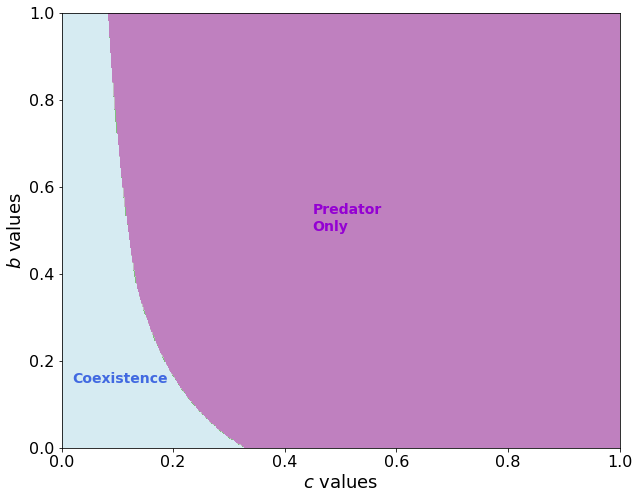

In [53]:
# --- Plotting ---
fig_c_b = plt.figure(figsize=(10, 8))

# --- Single Plot: b vs c ---
im_c_b = plt.imshow(region_data_c_b, cmap=cmap_c_b,
                    extent=[c_array_c_b.min(), c_array_c_b.max(), b_array_c_b.min(), b_array_c_b.max()],
                    origin='lower', aspect='auto', alpha=0.5)

# Overlay hatches for cycles
plt.contourf(c_grid_c_b, b_grid_c_b, constrained_mask_cycles_H_c_b.astype(int),
             levels=[0.5, 1.5], colors='none', hatches=['////'], alpha=0)

plt.contourf(c_grid_c_b, b_grid_c_b, constrained_mask_cycles_P_c_b.astype(int),
             levels=[0.5, 1.5], colors='none', hatches=['\\\\'], alpha=0)

# Labels and formatting
#plt.text(0.0, 1.01, 'A', color='black', fontsize=18, fontweight='bold', transform=plt.gca().transAxes)
plt.text(0.45, 0.5, 'Predator\nOnly', color='darkviolet', fontsize=14, fontweight='bold', transform=plt.gca().transAxes)
plt.text(0.02, 0.15, 'Coexistence', color='royalblue', fontsize=14, fontweight='bold', transform=plt.gca().transAxes)
plt.xlabel("$c$ values", fontsize=18)
plt.ylabel("$b$ values", fontsize=18)
plt.tick_params(axis='both', labelsize=16)

plt.savefig("manuscript_figs/b_c_regions.jpg",
            format='jpeg',
            dpi=300,
            bbox_inches='tight')

plt.show()

# Different $E_P$ Values

In [34]:
# --- Step 1: Data Preparation (Calculation) ---
# Initialize arrays to store data
region_data_all = []
H_last_all, P_last_all = [], []
mask_cycles_H_all, mask_cycles_P_all = [], []

# Set the E_P values for each subplot
E_P_values = [0.0, 0.2, 0.4]

# Loop over each E_P value
for E_P_val in E_P_values:
    parameters_dict_c_b['E_P'] = E_P_val

    # Initialize arrays for this E_P value
    region_data_sub = np.zeros((size, size))
    H_last_sub, P_last_sub = np.zeros((size, size)), np.zeros((size, size))
    mask_cycles_H_sub = np.zeros((size, size), dtype=bool)
    mask_cycles_P_sub = np.zeros((size, size), dtype=bool)

    # Loop over b and c values
    for i in range(size):
        for j in range(size):
            b_c_b = b_array_c_b[i]
            c_c_b = c_array_c_b[j]
            parameters_dict_c_b['b'] = b_c_b
            parameters_dict_c_b['c'] = c_c_b  # Set c value

            # Run the model with the current b, c, and E_P values
            H_array_c_b, P_array_c_b, _, _ = run_model(H0, P0, parameters_dict_c_b)

            H_tail_c_b = H_array_c_b[-tail_length:]
            P_tail_c_b = P_array_c_b[-tail_length:]
            H_last_sub[i, j] = np.mean(H_tail_c_b)
            P_last_sub[i, j] = np.mean(P_tail_c_b)

            mask_cycles_H_sub[i, j] = detect_cycles(H_tail_c_b)
            mask_cycles_P_sub[i, j] = detect_cycles(P_tail_c_b)

    # Define regions for each subplot
    mask_P_dominated_sub = (H_last_sub < prey_extinction) & (P_last_sub > predator_extinction)
    mask_H_dominated_sub = (P_last_sub < predator_extinction) & (H_last_sub > prey_extinction)
    mask_extinction_sub = (H_last_sub < prey_extinction) & (P_last_sub < predator_extinction)
    mask_coexistence_sub = (H_last_sub > prey_extinction) & (P_last_sub > predator_extinction)

    region_data_sub[mask_extinction_sub] = 1
    region_data_sub[mask_P_dominated_sub] = 2
    region_data_sub[mask_H_dominated_sub] = 3
    region_data_sub[mask_coexistence_sub] = 4

    constrained_mask_cycles_H_sub = mask_cycles_H_sub & mask_coexistence_sub
    constrained_mask_cycles_P_sub = mask_cycles_P_sub & mask_coexistence_sub

    # Append to the list
    region_data_all.append(region_data_sub)
    H_last_all.append(H_last_sub)
    P_last_all.append(P_last_sub)
    mask_cycles_H_all.append(constrained_mask_cycles_H_sub)
    mask_cycles_P_all.append(constrained_mask_cycles_P_sub)

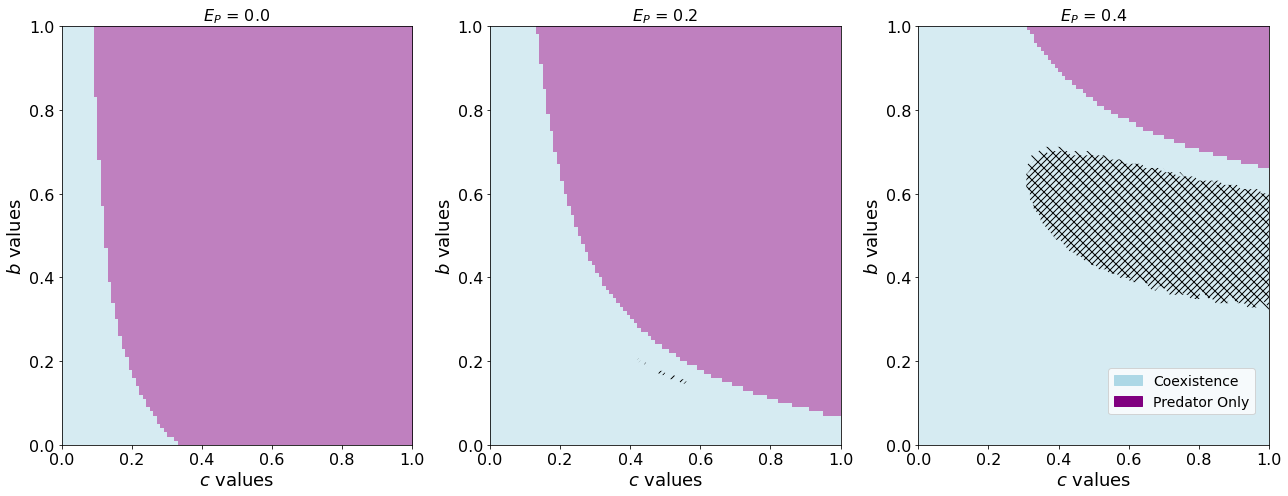

In [41]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt 

#--- Step 2: Plotting ---
# Create subplots
fig_c_b, axs_c_b = plt.subplots(1, 3, figsize=(18, 7))

# Loop through each E_P value and plot
for idx, E_P_val in enumerate(E_P_values):
    region_data_sub = region_data_all[idx]
    mask_cycles_H_sub = mask_cycles_H_all[idx]
    mask_cycles_P_sub = mask_cycles_P_all[idx]

    # Plot for the current E_P value
    im_sub = axs_c_b[idx].imshow(region_data_sub, cmap=cmap_c_b,
                                  extent=[c_array_c_b.min(), c_array_c_b.max(), b_array_c_b.min(), b_array_c_b.max()],
                                  origin='lower', aspect='auto', alpha=0.5)

    # Overlay hatches for cycles
    axs_c_b[idx].contourf(c_grid_c_b, b_grid_c_b, mask_cycles_H_sub.astype(int),
                          levels=[0.5, 1.5], colors='none', hatches=['////'], alpha=0)
    axs_c_b[idx].contourf(c_grid_c_b, b_grid_c_b, mask_cycles_P_sub.astype(int),
                          levels=[0.5, 1.5], colors='none', hatches=['\\\\'], alpha=0)

    # Labels and formatting
    axs_c_b[idx].set_title(f"$E_P$ = {E_P_val}", fontsize=16)
    axs_c_b[idx].set_xlabel("$c$ values", fontsize=18)
    axs_c_b[idx].set_ylabel("$b$ values", fontsize=18)
    axs_c_b[idx].tick_params(axis='both', labelsize=16)

# Create custom legend handles
coexistence_patch = mpatches.Patch(color='lightblue', label='Coexistence')
predator_only_patch = mpatches.Patch(color='purple', label='Predator Only')

# Add the legend
plt.legend(handles=[coexistence_patch, predator_only_patch], loc='upper center', bbox_to_anchor=(0.75, 0.2), fontsize=14)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


## Supplemental Fig 5 - b, c, & EP values

In [11]:
# Set b_array and E_P_array for the first plot
size = 100
b_array = np.linspace(0, 1.0, size)  # Example range of b values
E_P_array = np.linspace(0, 2.0, size)  # Example range of E_P values

# Define a small threshold
predator_extinction = 10
prey_extinction = 50

# Create an empty region data array
region_data_b = np.zeros((size, size))
region_data_c = np.zeros((size, size))


# Initialize arrays to store the last values of H and P for the first plot
H_last_b = np.zeros((size, size))
P_last_b = np.zeros((size, size))

# Run the model for each combination of b and E_P
for i in range(size):
    for j in range(size):
        b = b_array[i]
        E_P = E_P_array[j]
        parameters_dict['c'] = 0.4
        parameters_dict['b'] = b
        parameters_dict['E_P'] = E_P
        H_array, P_array, H_harvest_array, P_harvest_array = run_model(H0, P0, parameters_dict)
        H_last_b[i, j] = np.mean(H_array[-10:])  # Take the mean of the last 10 values
        P_last_b[i, j] = np.mean(P_array[-10:])

        
# Create masks with a threshold for near-zero conditions for b values
mask_P_dominated_b = (H_last_b < prey_extinction) & (P_last_b > predator_extinction) # Predator domination (H ≈ 0, P > 0)
mask_H_dominated_b = (P_last_b < predator_extinction) & (H_last_b > prey_extinction) # Prey domination (H > 0, P ≈ 0)
mask_extinction_b = (H_last_b < prey_extinction) & (P_last_b < predator_extinction)  # Extinction (H ≈ 0, P ≈ 0)
mask_coexistence_b = (H_last_b > prey_extinction) & (P_last_b > predator_extinction)  # Coexistence (H > 0, P > 0)

# Populate the region_data array with the mask values
region_data_b[mask_extinction_b] = 1
region_data_b[mask_P_dominated_b] = 2
region_data_b[mask_H_dominated_b] = 3
region_data_b[mask_coexistence_b] = 4        

# Set c_array for the second plot
c_array = np.linspace(0, 1.0, size)  # Example range of c values

# Initialize arrays to store the last values of H and P for the second plot
H_last_c = np.zeros((size, size))
P_last_c = np.zeros((size, size))

# Run the model for each combination of c and E_P
for i in range(size):
    for j in range(size):
        c = c_array[i]
        E_P = E_P_array[j]
        parameters_dict['c'] = c
        parameters_dict['b'] = 0.4
        parameters_dict['E_P'] = E_P
        H_array, P_array, H_harvest_array, P_harvest_array = run_model(H0, P0, parameters_dict)
        H_last_c[i, j] = np.mean(H_array[-10:])  # Take the mean of the last 10 values
        P_last_c[i, j] = np.mean(P_array[-10:])

# Create masks with a threshold for near-zero conditions for c values
mask_P_dominated_c = (H_last_c < prey_extinction) & (P_last_c > predator_extinction) # Predator domination (H ≈ 0, P > 0)
mask_H_dominated_c = (P_last_c < predator_extinction) & (H_last_c > prey_extinction) # Prey domination (H > 0, P ≈ 0)
mask_extinction_c = (H_last_c < prey_extinction) & (P_last_c < predator_extinction)  # Extinction (H ≈ 0, P ≈ 0)
mask_coexistence_c = (H_last_c > prey_extinction) & (P_last_c > predator_extinction)  # Coexistence (H > 0, P > 0)

# Populate the region_data array with the mask values
region_data_c[mask_extinction_c] = 1
region_data_c[mask_P_dominated_c] = 2
region_data_c[mask_H_dominated_c] = 3
region_data_c[mask_coexistence_c] = 4

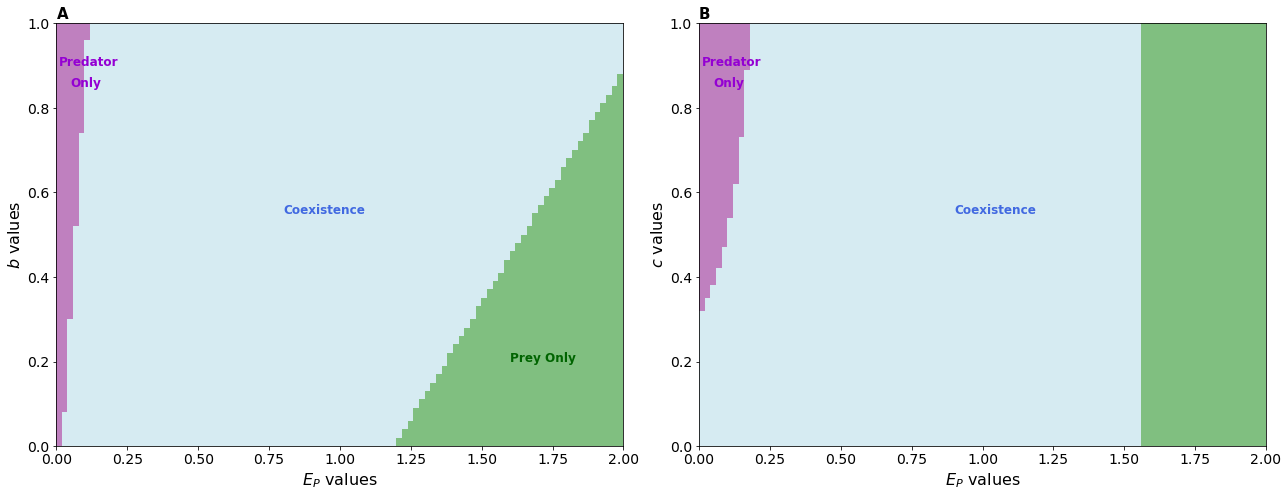

In [12]:
# Create colormap for qualitative regions
cmap = ListedColormap(['purple', 'gray', 'green', 'lightblue'])

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(18, 7))

# First subplot - b values and EP values
axs[0].imshow(region_data_b, cmap=cmap, extent=[min(E_P_array), max(E_P_array), min(b_array), max(b_array)], origin='lower', aspect='auto', alpha=0.5)
axs[0].text(0.0, 1.01, 'A', color='black', fontsize=15, fontweight='bold', transform=axs[0].transAxes)
axs[0].text(0.005, 0.9, 'Predator', color='darkviolet', fontsize=12, fontweight='bold', transform=axs[0].transAxes)
axs[0].text(0.025, 0.85, 'Only', color='darkviolet', fontsize=12, fontweight='bold', transform=axs[0].transAxes)
axs[0].text(0.4, 0.55, 'Coexistence', color='royalblue', fontsize=12, fontweight='bold', transform=axs[0].transAxes)
axs[0].text(0.8, 0.2, 'Prey Only', color='darkgreen', fontsize=12, fontweight='bold', transform=axs[0].transAxes)
axs[0].set_xlabel("$E_P$ values", fontsize=16)
axs[0].set_ylabel("$b$ values", fontsize=16)
axs[0].tick_params(axis='both', labelsize=14)

# Second subplot - c values and EP values
axs[1].imshow(region_data_c, cmap=cmap, extent=[min(E_P_array), max(E_P_array), min(c_array), max(c_array)], origin='lower', aspect='auto', alpha=0.5)
axs[1].text(0.0, 1.01, 'B', color='black', fontsize=15, fontweight='bold', transform=axs[1].transAxes)
axs[1].text(0.005, 0.9, 'Predator', color='darkviolet', fontsize=12, fontweight='bold', transform=axs[1].transAxes)
axs[1].text(0.025, 0.85, 'Only', color='darkviolet', fontsize=12, fontweight='bold', transform=axs[1].transAxes)
axs[1].text(0.45, 0.55, 'Coexistence', color='royalblue', fontsize=12, fontweight='bold', transform=axs[1].transAxes)
axs[1].set_xlabel("$E_P$ values", fontsize=16)
axs[1].set_ylabel("$c$ values", fontsize=16)
axs[1].tick_params(axis='both', labelsize=14)

# Adjust layout and show the plot
plt.tight_layout()

#plt.savefig("manuscript_figs/b_c_EP_regions.jpg",
 #           format='jpeg',
  #          dpi=300,
   #         bbox_inches='tight')

plt.show()

# Testing new detect_cycles function

In [31]:
def detect_cycles(ts, min_peaks=2, min_amplitude=10, tail_length=100):
    ts = np.asarray(ts)[-tail_length:]
    if (np.max(ts) - np.min(ts)) < min_amplitude:
        return False

    ts_centered = ts - np.mean(ts)
    peaks, _ = find_peaks(ts_centered, height=min_amplitude / 2)
    troughs, _ = find_peaks(-ts_centered, height=min_amplitude / 2)

    return (len(peaks) >= min_peaks) and (len(troughs) >= min_peaks)

size = 100
tail_length = 100

parameters_dict = default_params()
b_array = np.linspace(0, 1.0, size)
c_array = np.linspace(0, 1.0, size)
E_P_array = np.linspace(0, 2.0, size)

predator_extinction = 10
prey_extinction = 50

region_data_b = np.zeros((size, size))
region_data_c = np.zeros((size, size))

H_last_b, P_last_b = np.zeros((size, size)), np.zeros((size, size))

mask_cycles_H_b = np.zeros((size, size), dtype=bool)
mask_cycles_P_b = np.zeros((size, size), dtype=bool)

for i in range(size):
    for j in range(size):
        b = b_array[i]
        E_P = E_P_array[j]
        parameters_dict['b'] = b
        parameters_dict['E_P'] = E_P
        
        # Reset c to a default
        parameters_dict['c'] = 0.4
        
        H_array, P_array, _, _ = run_model(H0, P0, parameters_dict)

        H_tail = H_array[-tail_length:]
        P_tail = P_array[-tail_length:]
        H_last_b[i, j] = np.mean(H_tail)
        P_last_b[i, j] = np.mean(P_tail)

        mask_cycles_H_b[i, j] = detect_cycles(H_tail)
        mask_cycles_P_b[i, j] = detect_cycles(P_tail)

mask_P_dominated_b = (H_last_b < prey_extinction) & (P_last_b > predator_extinction)
mask_H_dominated_b = (P_last_b < predator_extinction) & (H_last_b > prey_extinction)
mask_extinction_b = (H_last_b < prey_extinction) & (P_last_b < predator_extinction)
mask_coexistence_b = (H_last_b > prey_extinction) & (P_last_b > predator_extinction)

region_data_b[mask_extinction_b] = 1
region_data_b[mask_P_dominated_b] = 2
region_data_b[mask_H_dominated_b] = 3
region_data_b[mask_coexistence_b] = 4

constrained_mask_cycles_H_b = mask_cycles_H_b & mask_coexistence_b
constrained_mask_cycles_P_b = mask_cycles_P_b & mask_coexistence_b

H_last_c, P_last_c = np.zeros((size, size)), np.zeros((size, size))

mask_cycles_H_c = np.zeros((size, size), dtype=bool)
mask_cycles_P_c = np.zeros((size, size), dtype=bool)

for i in range(size):
    for j in range(size):
        c = c_array[i]
        E_P = E_P_array[j]
        parameters_dict['c'] = c
        parameters_dict['E_P'] = E_P
        
        # Reset b to a default
        parameters_dict['b'] = 0.4 
        
        H_array, P_array, _, _ = run_model(H0, P0, parameters_dict)

        H_tail = H_array[-tail_length:]
        P_tail = P_array[-tail_length:]
        H_last_c[i, j] = np.mean(H_tail)
        P_last_c[i, j] = np.mean(P_tail)

        mask_cycles_H_c[i, j] = detect_cycles(H_tail)
        mask_cycles_P_c[i, j] = detect_cycles(P_tail)

mask_P_dominated_c = (H_last_c < prey_extinction) & (P_last_c > predator_extinction)
mask_H_dominated_c = (P_last_c < predator_extinction) & (H_last_c > prey_extinction)
mask_extinction_c = (H_last_c < prey_extinction) & (P_last_c < predator_extinction)
mask_coexistence_c = (H_last_c > prey_extinction) & (P_last_c > predator_extinction)

region_data_c[mask_extinction_c] = 1
region_data_c[mask_P_dominated_c] = 2
region_data_c[mask_H_dominated_c] = 3
region_data_c[mask_coexistence_c] = 4

constrained_mask_cycles_H_c = mask_cycles_H_c & mask_coexistence_c
constrained_mask_cycles_P_c = mask_cycles_P_c & mask_coexistence_c


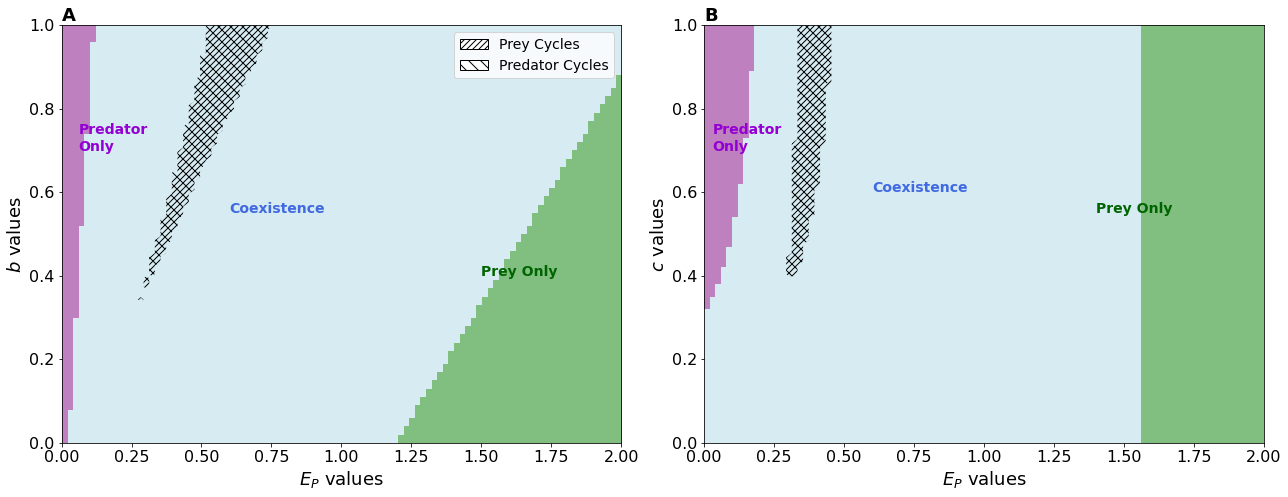

In [32]:
# Create meshgrids for contour alignment
EP_grid, b_grid = np.meshgrid(E_P_array, b_array)
EP_grid_c, c_grid = np.meshgrid(E_P_array, c_array)

# Define colormap for regions
cmap = ListedColormap(['purple', 'gray', 'green', 'lightblue'])

# --- Plotting ---
fig, axs = plt.subplots(1, 2, figsize=(18, 7))

# --- Panel A: b vs E_P ---
im_b = axs[0].imshow(region_data_b, cmap=cmap,
                     extent=[E_P_array.min(), E_P_array.max(), b_array.min(), b_array.max()],
                     origin='lower', aspect='auto', alpha=0.5)

# Overlay hatches for cycles
axs[0].contourf(EP_grid, b_grid, constrained_mask_cycles_H_b.astype(int),
                levels=[0.5, 1.5], colors='none', hatches=['////'], alpha=0)

axs[0].contourf(EP_grid, b_grid, constrained_mask_cycles_P_b.astype(int),
                levels=[0.5, 1.5], colors='none', hatches=['\\\\'], alpha=0)

# Labels and formatting
axs[0].text(0.0, 1.01, 'A', color='black', fontsize=18, fontweight='bold', transform=axs[0].transAxes)
axs[0].text(0.03, 0.7, 'Predator\nOnly', color='darkviolet', fontsize=14, fontweight='bold', transform=axs[0].transAxes)
axs[0].text(0.3, 0.55, 'Coexistence', color='royalblue', fontsize=14, fontweight='bold', transform=axs[0].transAxes)
axs[0].text(0.75, 0.4, 'Prey Only', color='darkgreen', fontsize=14, fontweight='bold', transform=axs[0].transAxes)
axs[0].set_xlabel("$E_P$ values", fontsize=18)
axs[0].set_ylabel("$b$ values", fontsize=18)
axs[0].tick_params(axis='both', labelsize=16)

# --- Panel B: c vs E_P ---
im_c = axs[1].imshow(region_data_c, cmap=cmap,
                     extent=[E_P_array.min(), E_P_array.max(), c_array.min(), c_array.max()],
                     origin='lower', aspect='auto', alpha=0.5)

# Overlay hatches for cycles
axs[1].contourf(EP_grid_c, c_grid, constrained_mask_cycles_H_c.astype(int),
                levels=[0.5, 1.5], colors='none', hatches=['////'], alpha=0)

axs[1].contourf(EP_grid_c, c_grid, constrained_mask_cycles_P_c.astype(int),
                levels=[0.5, 1.5], colors='none', hatches=['\\\\'], alpha=0)

# Labels and formatting
axs[1].text(0.0, 1.01, 'B', color='black', fontsize=18, fontweight='bold', transform=axs[1].transAxes)
axs[1].text(0.015, 0.7, 'Predator\nOnly', color='darkviolet', fontsize=14, fontweight='bold', transform=axs[1].transAxes)
axs[1].text(0.3, 0.6, 'Coexistence', color='royalblue', fontsize=14, fontweight='bold', transform=axs[1].transAxes)
axs[1].text(0.7, 0.55, 'Prey Only', color='darkgreen', fontsize=14, fontweight='bold', transform=axs[1].transAxes)
axs[1].set_xlabel("$E_P$ values", fontsize=18)
axs[1].set_ylabel("$c$ values", fontsize=18)
axs[1].tick_params(axis='both', labelsize=16)

# --- Legend ---
hatch_patch_H = Patch(facecolor='white', edgecolor='black', hatch='////', label='Prey Cycles')
hatch_patch_P = Patch(facecolor='white', edgecolor='black', hatch='\\\\', label='Predator Cycles')
axs[0].legend(handles=[hatch_patch_H, hatch_patch_P], loc='upper right', fontsize=14, frameon=True)

plt.tight_layout()

#plt.savefig("manuscript_figs/b_c_EP_regions_cycles.jpg",
 #           format='jpeg',
  #          dpi=300,
   #         bbox_inches='tight')

plt.show()

## Without Hatches

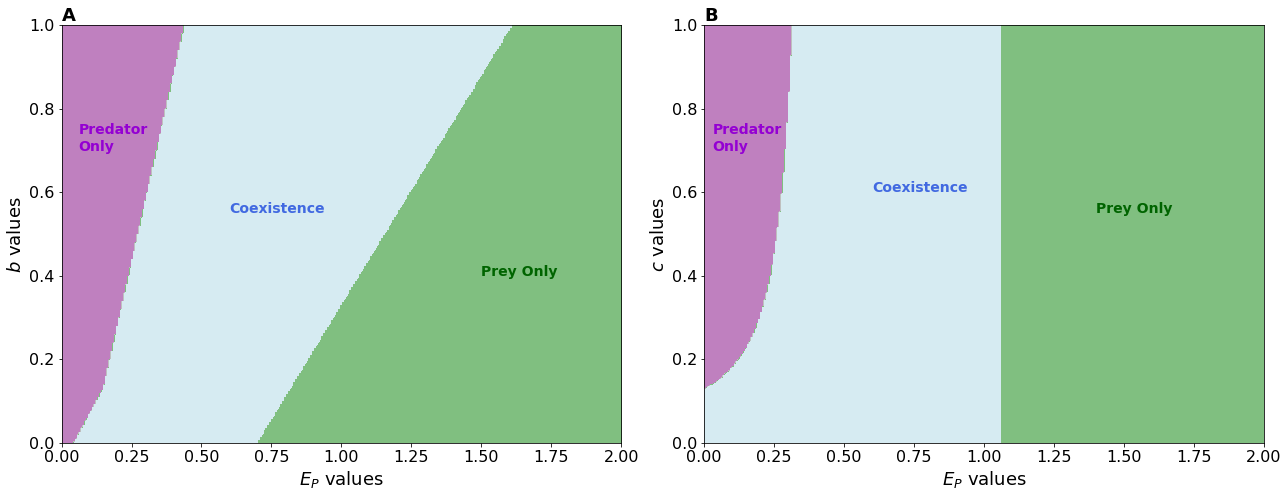

In [11]:
# Create meshgrids for contour alignment
EP_grid, b_grid = np.meshgrid(E_P_array, b_array)
EP_grid_c, c_grid = np.meshgrid(E_P_array, c_array)

# Define colormap for regions
cmap = ListedColormap(['purple', 'gray', 'green', 'lightblue'])

# --- Plotting ---
fig, axs = plt.subplots(1, 2, figsize=(18, 7))

# --- Panel A: b vs E_P ---
im_b = axs[0].imshow(region_data_b, cmap=cmap,
                     extent=[E_P_array.min(), E_P_array.max(), b_array.min(), b_array.max()],
                     origin='lower', aspect='auto', alpha=0.5)

# Overlay hatches for cycles
#axs[0].contourf(EP_grid, b_grid, constrained_mask_cycles_H_b.astype(int),
 #               levels=[0.5, 1.5], colors='none', hatches=['////'], alpha=0)

#axs[0].contourf(EP_grid, b_grid, constrained_mask_cycles_P_b.astype(int),
 #               levels=[0.5, 1.5], colors='none', hatches=['\\\\'], alpha=0)

# Labels and formatting
axs[0].text(0.0, 1.01, 'A', color='black', fontsize=18, fontweight='bold', transform=axs[0].transAxes)
axs[0].text(0.03, 0.7, 'Predator\nOnly', color='darkviolet', fontsize=14, fontweight='bold', transform=axs[0].transAxes)
axs[0].text(0.3, 0.55, 'Coexistence', color='royalblue', fontsize=14, fontweight='bold', transform=axs[0].transAxes)
axs[0].text(0.75, 0.4, 'Prey Only', color='darkgreen', fontsize=14, fontweight='bold', transform=axs[0].transAxes)
axs[0].set_xlabel("$E_P$ values", fontsize=18)
axs[0].set_ylabel("$b$ values", fontsize=18)
axs[0].tick_params(axis='both', labelsize=16)

# --- Panel B: c vs E_P ---
im_c = axs[1].imshow(region_data_c, cmap=cmap,
                     extent=[E_P_array.min(), E_P_array.max(), c_array.min(), c_array.max()],
                     origin='lower', aspect='auto', alpha=0.5)

# Overlay hatches for cycles
#axs[1].contourf(EP_grid_c, c_grid, constrained_mask_cycles_H_c.astype(int),
 #               levels=[0.5, 1.5], colors='none', hatches=['////'], alpha=0)

#axs[1].contourf(EP_grid_c, c_grid, constrained_mask_cycles_P_c.astype(int),
 #               levels=[0.5, 1.5], colors='none', hatches=['\\\\'], alpha=0)

# Labels and formatting
axs[1].text(0.0, 1.01, 'B', color='black', fontsize=18, fontweight='bold', transform=axs[1].transAxes)
axs[1].text(0.015, 0.7, 'Predator\nOnly', color='darkviolet', fontsize=14, fontweight='bold', transform=axs[1].transAxes)
axs[1].text(0.3, 0.6, 'Coexistence', color='royalblue', fontsize=14, fontweight='bold', transform=axs[1].transAxes)
axs[1].text(0.7, 0.55, 'Prey Only', color='darkgreen', fontsize=14, fontweight='bold', transform=axs[1].transAxes)
axs[1].set_xlabel("$E_P$ values", fontsize=18)
axs[1].set_ylabel("$c$ values", fontsize=18)
axs[1].tick_params(axis='both', labelsize=16)

# --- Legend ---
#hatch_patch_H = Patch(facecolor='white', edgecolor='black', hatch='////', label='Prey Cycles')
#hatch_patch_P = Patch(facecolor='white', edgecolor='black', hatch='\\\\', label='Predator Cycles')
#axs[0].legend(handles=[hatch_patch_H, hatch_patch_P], loc='upper right', fontsize=14, frameon=True)

plt.tight_layout()
plt.show()


In [12]:
# --- Report bounds of cyclic regions ---

# For Panel A (b vs E_P)
b_indices, ep_indices = np.where(constrained_mask_cycles_H_b | constrained_mask_cycles_P_b)
if len(b_indices) > 0:
    b_min, b_max = b_array[b_indices].min(), b_array[b_indices].max()
    ep_min, ep_max = E_P_array[ep_indices].min(), E_P_array[ep_indices].max()
    print(f"\nPanel A - Cyclical Region:")
    print(f"  b values range:    {b_min:.3f} to {b_max:.3f}")
    print(f"  E_P values range:  {ep_min:.3f} to {ep_max:.3f}")
else:
    print("\nPanel A - No cycles detected in coexistence region.")

# For Panel B (c vs E_P)
c_indices, ep_indices_c = np.where(constrained_mask_cycles_H_c | constrained_mask_cycles_P_c)
if len(c_indices) > 0:
    c_min, c_max = c_array[c_indices].min(), c_array[c_indices].max()
    ep_min_c, ep_max_c = E_P_array[ep_indices_c].min(), E_P_array[ep_indices_c].max()
    print(f"\nPanel B - Cyclical Region:")
    print(f"  c values range:    {c_min:.3f} to {c_max:.3f}")
    print(f"  E_P values range:  {ep_min_c:.3f} to {ep_max_c:.3f}")
else:
    print("\nPanel B - No cycles detected in coexistence region.")



Panel A - Cyclical Region:
  b values range:    0.187 to 1.000
  E_P values range:  0.187 to 0.776

Panel B - Cyclical Region:
  c values range:    0.341 to 1.000
  E_P values range:  0.281 to 0.462


## Testing individual time series 

In [33]:
numyears = 1000 # number of years to run simulation 

#Herbivore parameters:
r_H = 0.4 # growth rate of herbivores
K_H = 5000 # carrying capacity of herbivores
theta_H = 50 # immigration of herbivores
c = 0.4 #additional mortality of H 
d = 500 # value of H when predation half its max value 
q_H = 1. # proportionality constant for herbivore harvest 
E_H = 0.0 # Effort for herbivore harvest (0.05 = limit cycle, 0.2 = stable state)
#Predator parameters:
r_P = 0.2 # growth rate of predator 
K_P = 2000 # carrying capactiy of predators
b = 0.6 # additional growth of P due to H
theta_P = 10 # immigration of predators 
q_P = 1. # proportionality constant for predator harvest 
E_P = 0.15 # Effort for predator harvest

parameters_dict = {'numyears': numyears, 
                  'r_H': r_H, 
                  'K_H': K_H, 
                  'theta_H': theta_H,
                  'c': c, 
                  'd': d, 
                  'E_H': E_H,
                  'q_H': q_H, 
                  'r_P': r_P,
                  'K_P': K_P,
                  'theta_P': theta_P, 
                  'b': b,
                  'q_P': q_P, 
                  'E_P': E_P,
                  }

H0 = 100
P0 = 10

H_array, P_array, H_harvest_array, P_harvest_array = run_model(H0, P0, parameters_dict)

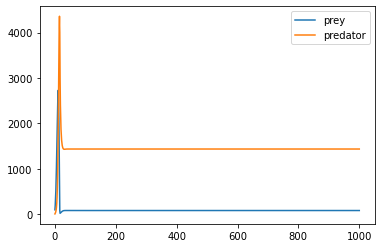

In [34]:
plt.plot(H_array, label ="prey")
plt.plot(P_array, label="predator")
plt.legend()

Prey cycle? False
Predator cycle? False


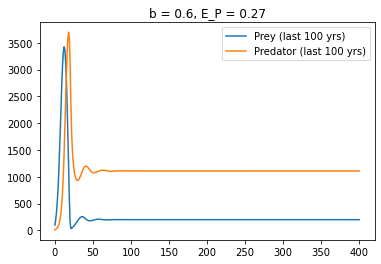

In [21]:
H_array, P_array, *_ = run_model(H0, P0, parameters_dict)

print("Prey cycle?", detect_cycles(H_array))
print("Predator cycle?", detect_cycles(P_array))

# Optional: visualize it
import matplotlib.pyplot as plt
plt.plot(H_array, label='Prey (last 100 yrs)')
plt.plot(P_array, label='Predator (last 100 yrs)')
plt.legend()
plt.title(f"b = {parameters_dict['b']}, E_P = {parameters_dict['E_P']}")
plt.show()

## Amplitude Contour Lines

In [13]:
# --- Cycle detection ---
def detect_cycles(ts, min_peaks=2, min_amplitude=10, tail_length=100):
    ts = np.asarray(ts)[-tail_length:]
    if (np.max(ts) - np.min(ts)) < min_amplitude:
        return False

    ts_centered = ts - np.mean(ts)
    peaks, _ = find_peaks(ts_centered, height=min_amplitude / 2)
    troughs, _ = find_peaks(-ts_centered, height=min_amplitude / 2)

    return (len(peaks) >= min_peaks) and (len(troughs) >= min_peaks)

# --- Setup ---
size = 300
b_array = np.linspace(0, 1.0, size)
c_array = np.linspace(0, 1.0, size)
E_P_array = np.linspace(0, 2.0, size)
parameters_dict = default_params()

predator_extinction = 20
prey_extinction = 250

region_data_b = np.zeros((size, size))
region_data_c = np.zeros((size, size))

amp_H_b = np.zeros((size, size))
amp_P_b = np.zeros((size, size))
amp_H_c = np.zeros((size, size))
amp_P_c = np.zeros((size, size))

# --- Run model for b vs E_P ---
H_last_b, P_last_b = np.zeros((size, size)), np.zeros((size, size))

for i in range(size):
    for j in range(size):
        b = b_array[i]
        E_P = E_P_array[j]
        parameters_dict['b'] = b
        parameters_dict['E_P'] = E_P
        parameters_dict['c'] = 0.4
        H_array, P_array, *_ = run_model(H0, P0, parameters_dict)

        H_tail = H_array[-100:]
        P_tail = P_array[-100:]
        H_last_b[i, j] = np.mean(H_tail)
        P_last_b[i, j] = np.mean(P_tail)
        amp_H_b[i, j] = np.ptp(H_tail)
        amp_P_b[i, j] = np.ptp(P_tail)

        if detect_cycles(H_tail) or detect_cycles(P_tail):
            region_data_b[i, j] = 5

mask_P_dominated_b = (H_last_b < prey_extinction) & (P_last_b > predator_extinction)
mask_H_dominated_b = (P_last_b < predator_extinction) & (H_last_b > prey_extinction)
mask_extinction_b = (H_last_b < prey_extinction) & (P_last_b < predator_extinction)
mask_coexistence_b = (H_last_b > prey_extinction) & (P_last_b > predator_extinction)

mask_cycles_b = region_data_b == 5
region_data_b[mask_cycles_b] = 4

region_data_b[mask_extinction_b] = 1
region_data_b[mask_P_dominated_b] = 2
region_data_b[mask_H_dominated_b] = 3
region_data_b[mask_coexistence_b] = 4

constrained_mask_cycles_b = mask_cycles_b & (region_data_b == 4)

# --- Run model for c vs E_P ---
H_last_c, P_last_c = np.zeros((size, size)), np.zeros((size, size))

for i in range(size):
    for j in range(size):
        c = c_array[i]
        E_P = E_P_array[j]
        parameters_dict['c'] = c
        parameters_dict['E_P'] = E_P
        parameters_dict['b'] = 0.4 
        H_array, P_array, *_ = run_model(H0, P0, parameters_dict)

        H_tail = H_array[-100:]
        P_tail = P_array[-100:]
        H_last_c[i, j] = np.mean(H_tail)
        P_last_c[i, j] = np.mean(P_tail)
        amp_H_c[i, j] = np.ptp(H_tail)
        amp_P_c[i, j] = np.ptp(P_tail)

        if detect_cycles(H_tail) or detect_cycles(P_tail):
            region_data_c[i, j] = 5

mask_P_dominated_c = (H_last_c < prey_extinction) & (P_last_c > predator_extinction)
mask_H_dominated_c = (P_last_c < predator_extinction) & (H_last_c > prey_extinction)
mask_extinction_c = (H_last_c < prey_extinction) & (P_last_c < predator_extinction)
mask_coexistence_c = (H_last_c > prey_extinction) & (P_last_c > predator_extinction)

mask_cycles_c = region_data_c == 5
region_data_c[mask_cycles_c] = 4

region_data_c[mask_extinction_c] = 1
region_data_c[mask_P_dominated_c] = 2
region_data_c[mask_H_dominated_c] = 3
region_data_c[mask_coexistence_c] = 4

constrained_mask_cycles_c = mask_cycles_c & (region_data_c == 4)

amp_H_b_masked = np.where(constrained_mask_cycles_b, amp_H_b, np.nan)
amp_P_b_masked = np.where(constrained_mask_cycles_b, amp_P_b, np.nan)

amp_H_c_masked = np.where(constrained_mask_cycles_c, amp_H_c, np.nan)
amp_P_c_masked = np.where(constrained_mask_cycles_c, amp_P_c, np.nan)

## Plotting

/Users/SophiaRahnke/opt/miniconda3/envs/py36test/lib/python3.6/site-packages/ipykernel_launcher.py:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


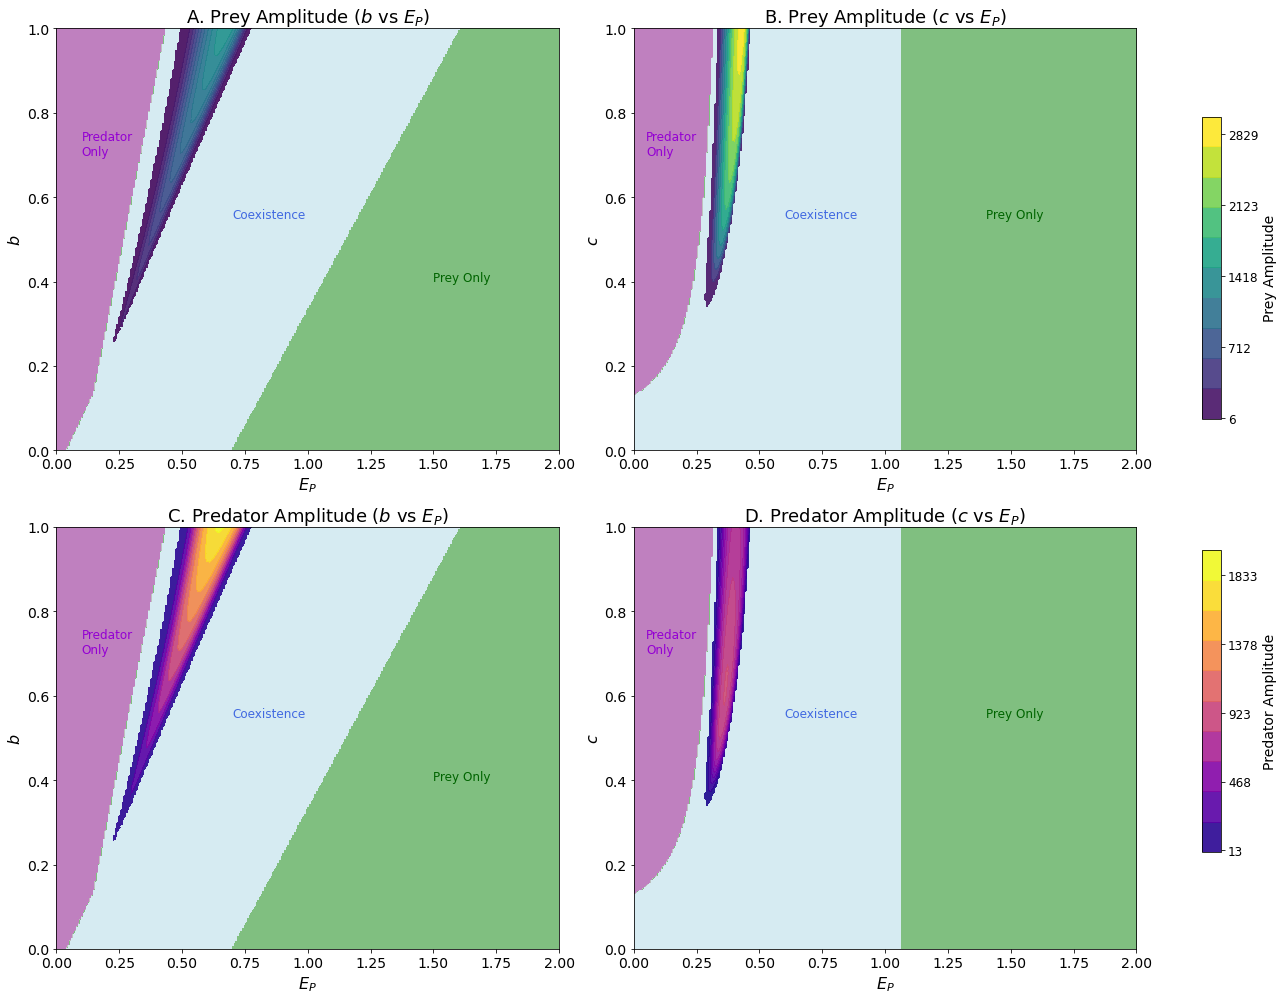

In [14]:
amp_H_b_masked = np.where(constrained_mask_cycles_b, amp_H_b, np.nan)
amp_P_b_masked = np.where(constrained_mask_cycles_b, amp_P_b, np.nan)

amp_H_c_masked = np.where(constrained_mask_cycles_c, amp_H_c, np.nan)
amp_P_c_masked = np.where(constrained_mask_cycles_c, amp_P_c, np.nan)

# Set shared vmin/vmax for colorbars
vmin_H = np.nanmin([amp_H_b_masked, amp_H_c_masked])
vmax_H = np.nanmax([amp_H_b_masked, amp_H_c_masked])
vmin_P = np.nanmin(amp_P_b_masked)
vmax_P = np.nanmax(amp_P_b_masked)

# Prey colorbar ticks
prey_ticks = np.linspace(vmin_H, vmax_H, num=5)

# Predator colorbar ticks
pred_ticks = np.linspace(vmin_P, vmax_P, num=5)

# --- Colormaps ---
cmap_regions = ListedColormap(['purple', 'gray', 'green', 'lightblue'])

fig, axs = plt.subplots(2, 2, figsize=(18, 14))

# Panel A: Prey amplitude for b
axs[0, 0].imshow(region_data_b, cmap=cmap_regions,
              extent=[min(E_P_array), max(E_P_array), min(b_array), max(b_array)],
              origin='lower', aspect='auto', alpha=0.5)

CS0 = axs[0, 0].contourf(E_P_array, b_array, amp_H_b_masked, 
                         levels=10, cmap='viridis', alpha=0.9, 
                         vmin=vmin_H, vmax=vmax_H)

axs[0, 0].set_title("A. Prey Amplitude ($b$ vs $E_P$)", fontsize=18)
axs[0, 0].set_xlabel("$E_P$", fontsize=16)
axs[0, 0].set_ylabel("$b$", fontsize=16)
axs[0, 0].tick_params(axis='both', labelsize=14)
axs[0, 0].text(0.05, 0.7, 'Predator\nOnly', transform=axs[0, 0].transAxes, fontsize=12, color='darkviolet')
axs[0, 0].text(0.35, 0.55, 'Coexistence', transform=axs[0, 0].transAxes, fontsize=12, color='royalblue')
axs[0, 0].text(0.75, 0.4, 'Prey Only', transform=axs[0, 0].transAxes, fontsize=12, color='darkgreen')

# Panel B: Prey amplitude for c
axs[0, 1].imshow(region_data_c, cmap=cmap_regions,
              extent=[min(E_P_array), max(E_P_array), min(c_array), max(c_array)],
              origin='lower', aspect='auto', alpha=0.5)

CS1 = axs[0, 1].contourf(E_P_array, c_array, amp_H_c_masked, 
                         levels=10, cmap='viridis', alpha=0.9, 
                         vmin=vmin_H, vmax=vmax_H)

axs[0, 1].set_title("B. Prey Amplitude ($c$ vs $E_P$)", fontsize=18)
axs[0, 1].set_xlabel("$E_P$", fontsize=16)
axs[0, 1].set_ylabel("$c$", fontsize=16)
axs[0, 1].tick_params(axis='both', labelsize=14)
axs[0, 1].text(0.025, 0.7, 'Predator\nOnly', transform=axs[0, 1].transAxes, fontsize=12, color='darkviolet')
axs[0, 1].text(0.3, 0.55, 'Coexistence', transform=axs[0, 1].transAxes, fontsize=12, color='royalblue')
axs[0, 1].text(0.7, 0.55, 'Prey Only', transform=axs[0, 1].transAxes, fontsize=12, color='darkgreen')

# Panel C: Predator amplitude for b
axs[1, 0].imshow(region_data_b, cmap=cmap_regions,
              extent=[min(E_P_array), max(E_P_array), min(b_array), max(b_array)],
              origin='lower', aspect='auto', alpha=0.5)

CS2 = axs[1, 0].contourf(E_P_array, b_array, amp_P_b_masked, 
                         levels=10, cmap='plasma', alpha=0.9, 
                         vmin=vmin_P, vmax=vmax_P)

axs[1, 0].set_title("C. Predator Amplitude ($b$ vs $E_P$)", fontsize=18)
axs[1, 0].set_xlabel("$E_P$", fontsize=16)
axs[1, 0].set_ylabel("$b$", fontsize=16)
axs[1, 0].tick_params(axis='both', labelsize=14)
axs[1, 0].text(0.05, 0.7, 'Predator\nOnly', transform=axs[1, 0].transAxes, fontsize=12, color='darkviolet')
axs[1, 0].text(0.35, 0.55, 'Coexistence', transform=axs[1, 0].transAxes, fontsize=12, color='royalblue')
axs[1, 0].text(0.75, 0.4, 'Prey Only', transform=axs[1, 0].transAxes, fontsize=12, color='darkgreen')

# Panel D: Predator amplitude for c
axs[1, 1].imshow(region_data_c, cmap=cmap_regions,
              extent=[min(E_P_array), max(E_P_array), min(c_array), max(c_array)],
              origin='lower', aspect='auto', alpha=0.5)

CS3 = axs[1, 1].contourf(E_P_array, c_array, amp_P_c_masked, 
                         levels=10, cmap='plasma', alpha=0.9, 
                         vmin=vmin_P, vmax=vmax_P)

axs[1, 1].set_title("D. Predator Amplitude ($c$ vs $E_P$)", fontsize=18)
axs[1, 1].set_xlabel("$E_P$", fontsize=16)
axs[1, 1].set_ylabel("$c$", fontsize=16)
axs[1, 1].tick_params(axis='both', labelsize=14)
axs[1, 1].text(0.025, 0.7, 'Predator\nOnly', transform=axs[1, 1].transAxes, fontsize=12, color='darkviolet')
axs[1, 1].text(0.3, 0.55, 'Coexistence', transform=axs[1, 1].transAxes, fontsize=12, color='royalblue')
axs[1, 1].text(0.7, 0.55, 'Prey Only', transform=axs[1, 1].transAxes, fontsize=12, color='darkgreen')

# Colorbars
cbar_ax1 = fig.add_axes([0.93, 0.58, 0.015, 0.3])
cbar1 = fig.colorbar(CS1, cax=cbar_ax1, ticks=prey_ticks)
cbar1.set_label("Prey Amplitude", fontsize=14)
cbar1.ax.tick_params(labelsize=12)

cbar_ax2 = fig.add_axes([0.93, 0.15, 0.015, 0.3])
cbar2 = fig.colorbar(CS2, cax=cbar_ax2, ticks=pred_ticks)
cbar2.set_label("Predator Amplitude", fontsize=14)
cbar2.ax.tick_params(labelsize=12)

plt.tight_layout(rect=[0, 0, 0.9, 1])

plt.savefig("manuscript_figs/b_c_EP_regions_amplitude.jpg",
            format='jpeg',
            dpi=300,
            bbox_inches='tight')

plt.show()


# Amplitude Time Series

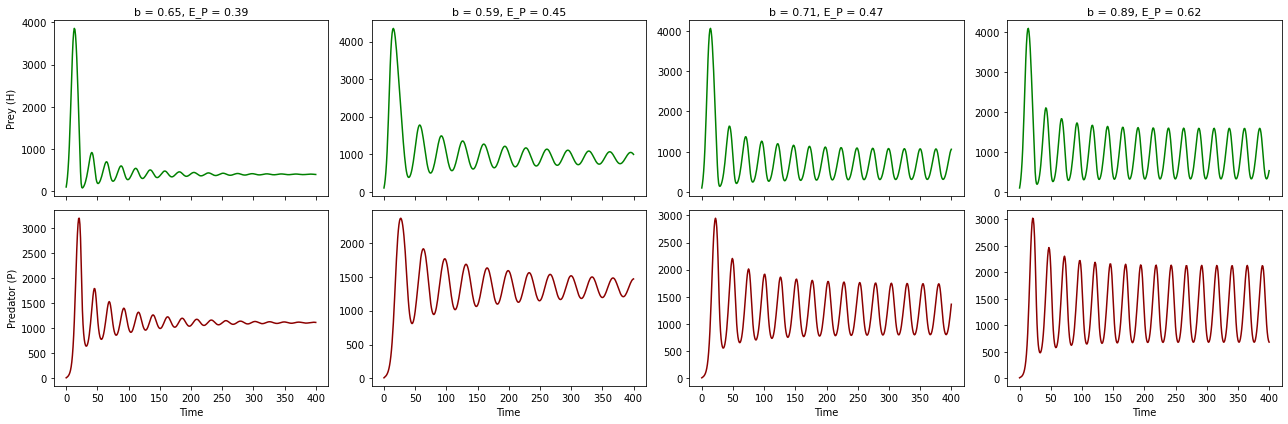

In [57]:
parameters_dict = default_params()
# Select 4 predator amplitude percentiles from b vs E_P space
valid_amps = amp_P_b_masked[~np.isnan(amp_P_b_masked)]
percentiles = [10, 40, 70, 90]
amp_thresholds = np.percentile(valid_amps, percentiles)

# Identify (i, j) closest to each percentile
selected_indices = []
for val in amp_thresholds:
    diff = np.abs(amp_P_b_masked - val)
    diff[~constrained_mask_cycles_b] = np.nan
    idx = np.unravel_index(np.nanargmin(diff), diff.shape)
    selected_indices.append(idx)

# Simulate time series for each (b, E_P) pair
fig, axs = plt.subplots(2, 4, figsize=(18, 6), sharex=True)
#time = np.arange(400)  # assuming 400 years

for k, (i, j) in enumerate(selected_indices):
    b_val = b_array[i]
    ep_val = E_P_array[j]
    params = parameters_dict.copy()
    params.update({'b': b_val, 'c': 0.4, 'E_P': ep_val})
    
    H_array, P_array, *_ = run_model(H0, P0, params)
    time = np.arange(len(H_array))  # <-- dynamically match the model output
    
    axs[0, k].plot(time, H_array, color='green')
    axs[0, k].set_title(f"b = {b_val:.2f}, E_P = {ep_val:.2f}", fontsize=11)
    axs[1, k].plot(time, P_array, color='darkred')
    
    if k == 0:
        axs[0, k].set_ylabel("Prey (H)")
        axs[1, k].set_ylabel("Predator (P)")

for ax in axs[1]:
    ax.set_xlabel("Time")

plt.tight_layout()
plt.show()

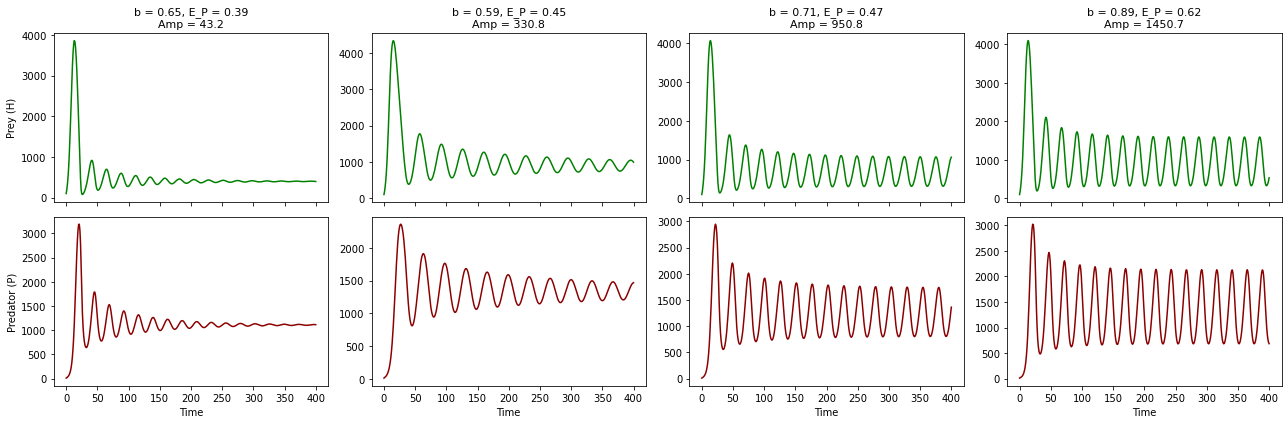

In [58]:
parameters_dict = default_params()
# Select 4 predator amplitude percentiles from b vs E_P space
valid_amps = amp_P_b_masked[~np.isnan(amp_P_b_masked)]
percentiles = [10, 40, 70, 90]
amp_thresholds = np.percentile(valid_amps, percentiles)

# Identify (i, j) closest to each percentile
selected_indices = []
for val in amp_thresholds:
    diff = np.abs(amp_P_b_masked - val)
    diff[~constrained_mask_cycles_b] = np.nan
    idx = np.unravel_index(np.nanargmin(diff), diff.shape)
    selected_indices.append(idx)

# Simulate time series for each (b, E_P) pair
fig, axs = plt.subplots(2, 4, figsize=(18, 6), sharex=True)
#time = np.arange(400)  # assuming 400 years

for k, (i, j) in enumerate(selected_indices):
    b_val = b_array[i]
    ep_val = E_P_array[j]
    amp_val = amp_P_b_masked[i, j]  # Get amplitude for labeling

    params = parameters_dict.copy()
    params.update({'b': b_val, 'c': 0.4, 'E_P': ep_val})
    
    H_array, P_array, *_ = run_model(H0, P0, params)
    time = np.arange(len(H_array))
    
    axs[0, k].plot(time, H_array, color='green')
    axs[0, k].set_title(f"b = {b_val:.2f}, E_P = {ep_val:.2f}\nAmp = {amp_val:.1f}", fontsize=11)
    axs[1, k].plot(time, P_array, color='darkred')
    
    if k == 0:
        axs[0, k].set_ylabel("Prey (H)")
        axs[1, k].set_ylabel("Predator (P)")

for ax in axs[1]:
    ax.set_xlabel("Time")

plt.tight_layout()
plt.show()

# $b$ and $E_P$ amplitudes 

# $b$ and pred amp

In [35]:
parameters_dict = default_params()
# Select 4 predator amplitude percentiles from b vs E_P space
valid_amps = amp_P_b_masked[~np.isnan(amp_P_b_masked)]
percentiles = [10, 40, 70, 90]
amp_thresholds = np.percentile(valid_amps, percentiles)

# Identify (i, j) closest to each percentile
selected_indices = []
for val in amp_thresholds:
    diff = np.abs(amp_P_b_masked - val)
    diff[~constrained_mask_cycles_b] = np.nan
    idx = np.unravel_index(np.nanargmin(diff), diff.shape)
    selected_indices.append(idx)

fig, axs = plt.subplots(1, 4, figsize=(20, 4), sharex=True)

for k, (i, j) in enumerate(selected_indices):
    b_val = b_array[i]
    ep_val = E_P_array[j]
    amp_H = amp_H_b_masked[i, j]
    amp_P = amp_P_b_masked[i, j]

    params = parameters_dict.copy()
    params.update({'b': b_val, 'c': 0.4, 'E_P': ep_val})
    
    H_array, P_array, *_ = run_model(H0, P0, params)
    time = np.arange(len(H_array))
    
    axs[k].plot(time, H_array, color='limegreen', label='Prey ($N$)')
    axs[k].plot(time, P_array, color='purple', label='Predator ($P$)')
    
    axs[k].set_title(
    f"{percentiles[k]}th Percentile Amplitude\nb = {b_val:.2f}, Eₚ = {ep_val:.2f}",
    fontsize=11
    )

    axs[k].text(
    0.95, 0.95,
    f"$N$ Amp. = {amp_H:.1f}\n$P$ Amp. = {amp_P:.1f}",
    transform=axs[k].transAxes,
    fontsize=10,
    ha='right',
    va='top',
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='none')
    )

    axs[k].set_xlabel("Time")
    axs[k].tick_params(labelsize=10)
    if k == 0:
        axs[k].set_ylabel("Biomass")
        axs[k].legend(loc='center right', fontsize=9)

plt.tight_layout()
plt.show()


NameError: name 'amp_P_b_masked' is not defined

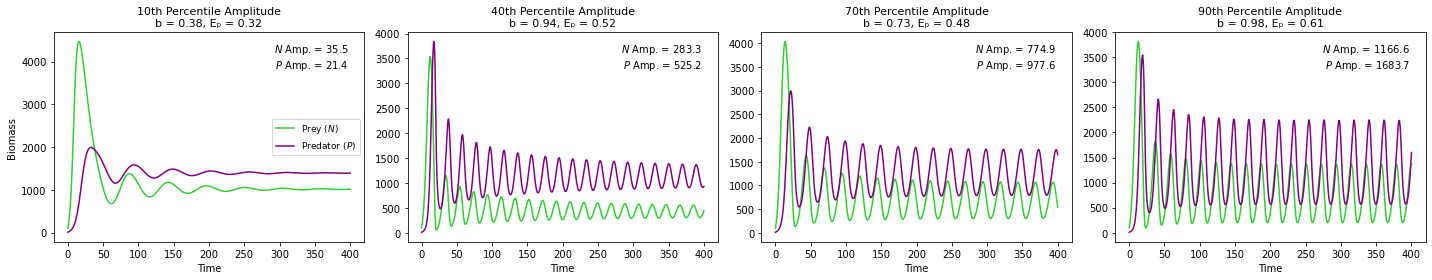

In [104]:
parameters_dict = default_params()
# Select 4 predator amplitude percentiles from b vs E_P space
valid_amps = amp_H_b_masked[~np.isnan(amp_H_b_masked)]
percentiles = [10, 40, 70, 90]
amp_thresholds = np.percentile(valid_amps, percentiles)

# Identify (i, j) closest to each percentile
selected_indices = []
for val in amp_thresholds:
    diff = np.abs(amp_H_b_masked - val)
    diff[~constrained_mask_cycles_b] = np.nan
    idx = np.unravel_index(np.nanargmin(diff), diff.shape)
    selected_indices.append(idx)

fig, axs = plt.subplots(1, 4, figsize=(20, 4), sharex=True)

for k, (i, j) in enumerate(selected_indices):
    b_val = b_array[i]
    ep_val = E_P_array[j]
    amp_H = amp_H_b_masked[i, j]
    amp_P = amp_P_b_masked[i, j]

    params = parameters_dict.copy()
    params.update({'b': b_val, 'c': 0.4, 'E_P': ep_val})
    
    H_array, P_array, *_ = run_model(H0, P0, params)
    time = np.arange(len(H_array))
    
    axs[k].plot(time, H_array, color='limegreen', label='Prey ($N$)')
    axs[k].plot(time, P_array, color='purple', label='Predator ($P$)')
    
    axs[k].set_title(
    f"{percentiles[k]}th Percentile Amplitude\nb = {b_val:.2f}, Eₚ = {ep_val:.2f}",
    fontsize=11
    )

    axs[k].text(
    0.95, 0.95,
    f"$N$ Amp. = {amp_H:.1f}\n$P$ Amp. = {amp_P:.1f}",
    transform=axs[k].transAxes,
    fontsize=10,
    ha='right',
    va='top',
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='none')
    )

    axs[k].set_xlabel("Time")
    axs[k].tick_params(labelsize=10)
    if k == 0:
        axs[k].set_ylabel("Biomass")
        axs[k].legend(loc='center right', fontsize=9)

plt.tight_layout()
plt.show()


# $C$ and $E_P$ Amplitudes

# $c$ and pred amp

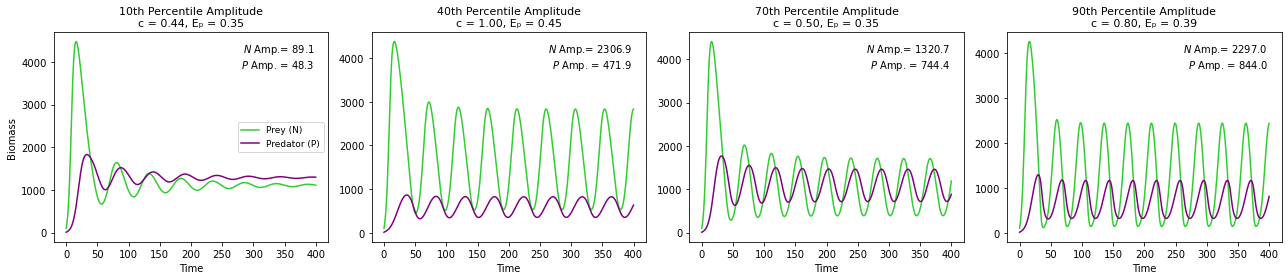

In [93]:
parameters_dict = default_params()

# Select 4 predator amplitude percentiles from c vs E_P space
valid_amps = amp_P_c_masked[~np.isnan(amp_P_c_masked)]
percentiles = [10, 40, 70, 90]
amp_thresholds = np.percentile(valid_amps, percentiles)

# Identify (i, j) closest to each percentile
selected_indices = []
for val in amp_thresholds:
    diff = np.abs(amp_P_c_masked - val)
    diff[~constrained_mask_cycles_c] = np.nan
    idx = np.unravel_index(np.nanargmin(diff), diff.shape)
    selected_indices.append(idx)

# Plotting time series
fig, axs = plt.subplots(1, 4, figsize=(18, 4), sharex=True)
for k, (i, j) in enumerate(selected_indices):
    c_val = c_array[i]
    ep_val = E_P_array[j]
    amp_P = amp_P_c_masked[i, j]
    amp_H = amp_H_c_masked[i, j]

    params = parameters_dict.copy()
    params.update({'c': c_val, 'b': 0.4, 'E_P': ep_val})  # b fixed, c varies

    H_array, P_array, *_ = run_model(H0, P0, params)
    time = np.arange(len(H_array))

    axs[k].plot(time, H_array, color='limegreen', label='Prey (N)')
    axs[k].plot(time, P_array, color='purple', label='Predator (P)')

    axs[k].set_title(
        f"{percentiles[k]}th Percentile Amplitude\nc = {c_val:.2f}, Eₚ = {ep_val:.2f}",
        fontsize=11
    )

    axs[k].text(
        0.95, 0.95,
        f"$N$ Amp.= {amp_H:.1f}\n$P$ Amp. = {amp_P:.1f}",
        transform=axs[k].transAxes,
        fontsize=10,
        ha='right',
        va='top',
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none')
    )

    axs[k].set_xlabel("Time")
    if k == 0:
        axs[k].set_ylabel("Biomass")

# Optional: unified legend
axs[0].legend(loc='center right', fontsize=9)

plt.tight_layout()
plt.show()


# $c$ and prey amp

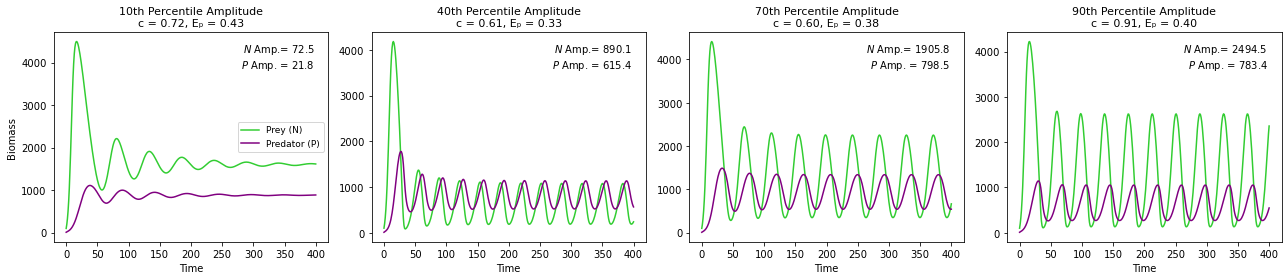

In [100]:
parameters_dict = default_params()

# Select 4 predator amplitude percentiles from c vs E_P space
valid_amps = amp_H_c_masked[~np.isnan(amp_H_c_masked)]
percentiles = [10, 40, 70, 90]
amp_thresholds = np.percentile(valid_amps, percentiles)

# Identify (i, j) closest to each percentile
selected_indices = []
for val in amp_thresholds:
    diff = np.abs(amp_H_c_masked - val)
    diff[~constrained_mask_cycles_c] = np.nan
    idx = np.unravel_index(np.nanargmin(diff), diff.shape)
    selected_indices.append(idx)

# Plotting time series
fig, axs = plt.subplots(1, 4, figsize=(18, 4), sharex=True)
for k, (i, j) in enumerate(selected_indices):
    c_val = c_array[i]
    ep_val = E_P_array[j]
    amp_P = amp_P_c_masked[i, j]
    amp_H = amp_H_c_masked[i, j]

    params = parameters_dict.copy()
    params.update({'c': c_val, 'b': 0.4, 'E_P': ep_val})  # b fixed, c varies

    H_array, P_array, *_ = run_model(H0, P0, params)
    time = np.arange(len(H_array))

    axs[k].plot(time, H_array, color='limegreen', label='Prey (N)')
    axs[k].plot(time, P_array, color='purple', label='Predator (P)')

    axs[k].set_title(
        f"{percentiles[k]}th Percentile Amplitude\nc = {c_val:.2f}, Eₚ = {ep_val:.2f}",
        fontsize=11
    )

    axs[k].text(
        0.95, 0.95,
        f"$N$ Amp.= {amp_H:.1f}\n$P$ Amp. = {amp_P:.1f}",
        transform=axs[k].transAxes,
        fontsize=10,
        ha='right',
        va='top',
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none')
    )

    axs[k].set_xlabel("Time")
    if k == 0:
        axs[k].set_ylabel("Biomass")

# Optional: unified legend
axs[0].legend(loc='center right', fontsize=9)

plt.tight_layout()
plt.show()
